In [ ]:
!pip install --upgrade diffusers transformers accelerate torch bitsandbytes scipy safetensors xformers

Initializing pipeline...
Using device: cuda


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Pipeline successfully initialized.
Generating image for prompt: 'boy in red shirt having pizza on mountain'...


  0%|          | 0/50 [00:00<?, ?it/s]

Image generation completed.


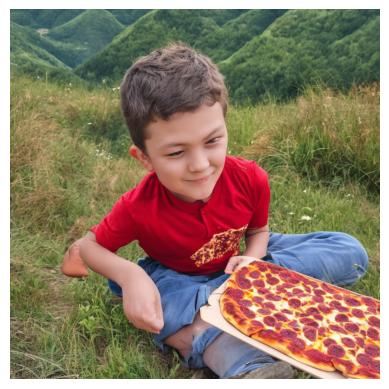

Image saved at: output/generated_image.png


In [3]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import matplotlib.pyplot as plt
from PIL import Image
import os
import argparse
from tqdm import tqdm
import sys


def setup_pipeline(model_id, device=None):
    """
    Set up the Stable Diffusion pipeline with the specified model ID and device.
    """
    try:
        print("Initializing pipeline...")
        # Auto-detect device if not specified
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")

        # Clear GPU cache if using CUDA
        if device == "cuda":
            torch.cuda.empty_cache()

        # Load the model
        pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16 if device == "cuda" else torch.float32)
        pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
        pipe = pipe.to(device)

        print("Pipeline successfully initialized.")
        return pipe
    except Exception as e:
        raise RuntimeError(f"Error setting up pipeline: {e}")


def generate_image(pipe, prompt, width=512, height=512, guidance_scale=7.5, seed=None):
    """
    Generate a single image based on the given prompt and parameters.
    """
    try:
        # Set the random seed for reproducibility
        generator = torch.manual_seed(seed) if seed is not None else None

        print(f"Generating image for prompt: '{prompt}'...")
        result = pipe(
            prompt=prompt,
            width=width,
            height=height,
            guidance_scale=guidance_scale,
            generator=generator,
        )
        print("Image generation completed.")
        return result.images[0]
    except Exception as e:
        raise RuntimeError(f"Error generating image: {e}")


def display_and_save_image(image, save_path=None):
    """
    Display the generated image and save it if a path is provided.
    """
    try:
        # Display the image
        plt.imshow(image)
        plt.axis("off")
        plt.show()

        # Save the image
        if save_path:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            image.save(save_path)
            print(f"Image saved at: {save_path}")
    except Exception as e:
        raise RuntimeError(f"Error displaying or saving image: {e}")


if __name__ == "__main__":
    # Handle extra Jupyter/Colab arguments
    if "ipykernel" in sys.modules:
        sys.argv = sys.argv[:1]

    # Command-line argument parsing
    parser = argparse.ArgumentParser(description="Generate images using Stable Diffusion.")
    parser.add_argument("--model_id", type=str, default="stabilityai/stable-diffusion-2-1", help="Stable Diffusion model ID")
    parser.add_argument("--prompt", type=str, default="boy in red shirt having pizza on mountain", help="Text prompt for image generation")
    parser.add_argument("--width", type=int, default=1024, help="Width of the generated image")
    parser.add_argument("--height", type=int, default=1024, help="Height of the generated image")
    parser.add_argument("--guidance_scale", type=float, default=7.5, help="Guidance scale for image generation")
    parser.add_argument("--seed", type=int, default=None, help="Random seed for reproducibility")
    parser.add_argument("--save_path", type=str, default="output/generated_image.png", help="Path to save the generated image")

    args = parser.parse_args()

    # Initialize pipeline
    pipeline = setup_pipeline(args.model_id)

    # Generate a single image
    image = generate_image(pipeline, args.prompt, args.width, args.height, args.guidance_scale, args.seed)
    display_and_save_image(image, args.save_path)
